# LangGraph

## **Inventory Management System with Conditional Graph**

This exercise requires building a small **Inventory Service** using a graph-based framework, such as **LangGraph**, complete with **conditional edges** for flow control. The goal is to process an order request (product and quantity) against a global inventory and manage the stock accordingly.

---

### Key Components and Logic

#### 1. Global State

A global **INVENTORY** dictionary will maintain stock levels:

$$INVENTORY = \{"tv": 8, "iphone": 6\}$$


\.

#### 2. Input

The graph accepts a tuple of:
* `product`: $\text{str}$ (The item requested)
* `quantity`: $\text{int}$ (The amount requested)


\.

#### 3. Conditional Branching (Router Node)

The main logic requires a router node that determines the next step based on the input and current inventory:

| Condition | Next Node | Inventory Action |
| :--- | :--- | :--- |
| **Product is unknown** (Not in `INVENTORY`) | $\rightarrow$ `unknown\_product\_message` | **No change** |
| **Stock is sufficient** (`quantity` $\le$ available units) | $\rightarrow$ `reserve` | **Decrement** stock |
| **Stock is insufficient** (`quantity` $>$ available units) | $\rightarrow$ `insufficient\_stock\_message` | **No change** |

---

### Required Node Actions

| Node | Action | Output |
| :--- | :--- | :--- |
| `reserve` | Decrement the count in the `INVENTORY` for the specified product. | $\rightarrow$ `success\_message` node. |
| `success\_message` | Return a clear **success confirmation** to the user. | Final output. |
| `unknown\_product\_message` | Return an **informative failure** stating the product is not stocked. | Final output. |
| `insufficient\_stock\_message` | Return an **informative failure** stating there's not enough stock available. | Final output. |

---

### Deliverables
Construct the full **LangGraph** flow with all required nodes and conditional edges.

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph


INVENTORY = {'tv': 8, 'iphone': 6}

class State(TypedDict, total = False):
  product:str
  product_exist: bool
  quantity:int
  availability:bool
  reserve:int
  response:str


def product_exist(state:State):
  if state.get('product') in INVENTORY.keys():
    return {'product_exist': True}
  return {'product_exist': False}


def route(state:State):
    return 'Exist' if state.get('product_exist') else 'Not Exist'



def unknow_product(state:State):
  '''
  Verify the product exist in inventory.
  '''
  return {'response': 'unknow product, inventory unchanged.'}



def validate_availability(state:State):
  '''
  Check wether enought units are avalaible.
  '''

  if 'tv' == state.get('product'):
      state['product_name'] = 'tv'
      if state.get('quantity') <= INVENTORY.get('tv'):
        return {'availability': True}

  if 'iphone'== state.get('product'):
      state['product_name'] = 'iphone'
      if state.get('quantity') <= INVENTORY.get('iphone'):
          return {'availability': True}


def route_available(state:State):
  return 'Available' if state.get('availability') else 'Not Available'



def reserve(state:State):
  '''
  Decrement inventory.
  '''

  if 'tv' == state.get('product'):
    reserve = INVENTORY.get('tv') - state.get('quantity')
    return {'reserve': reserve}
  if 'iphone'== state.get('product'):
    reserve = INVENTORY.get('iphone') - state.get('quantity')
    return {'reserve': reserve}


def success_message(state:State):
  total_reserve = state.get('reserve')
  return {'response': f"Success. {state.get('product')} decrease to {state.get('reserve')}."}


def insufficient_stock_message(state:State):
  return {'response': f"insufficient, inventory unchanged."}

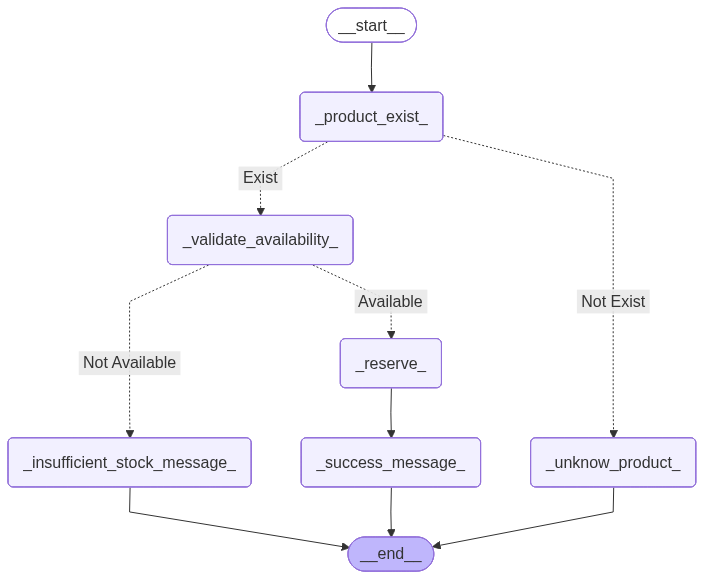

In [ ]:
builder = StateGraph(State)

# Create Nodes
builder.add_node('_product_exist_', product_exist)
builder.add_node('_unknow_product_', unknow_product)
builder.add_node('_validate_availability_', validate_availability)
builder.add_node('_reserve_', reserve)
builder.add_node('_success_message_', success_message)
builder.add_node('_insufficient_stock_message_', insufficient_stock_message)


# Create Edges
builder.add_edge(start_key = START, end_key = '_product_exist_')
builder.add_conditional_edges('_product_exist_', route, {'Exist': '_validate_availability_', 'Not Exist': '_unknow_product_'})
builder.add_edge(start_key = '_unknow_product_', end_key = END)
builder.add_conditional_edges('_validate_availability_', route_available, {'Available': '_reserve_', 'Not Available': '_insufficient_stock_message_'})
builder.add_edge(start_key = '_insufficient_stock_message_', end_key = END)
builder.add_edge(start_key = '_reserve_', end_key = '_success_message_')
builder.add_edge(start_key = '_success_message_', end_key = END)


graph = builder.compile()
graph

In [ ]:
def inventory(product:str, quantity:int) -> str:
   return graph.invoke({'product': product, 'quantity': quantity})['response']

print(inventory('tv', 3))
print(inventory('iphone', 7))
print(inventory('laptop', 1))

Success. tv decrease to 5.
insufficient, inventory unchanged.
unknow product, inventory unchanged.
